# Exercise - OLS violations  part 2

**(1)** Test for violations of the following OLS assumption: $cov(u_t, u_{t-1})=0$
> **(a)** Durbin and Watson (1951) test

> **(b)** Breusch and Godfrey autocorrelation test

**(2)** Propose corrections for violations of the assumption of no autocorrelation on the error terms:
> **(a)** Compare the static vs dynamic model in terms of AIC and BIC

**(3)** Test for violations of the full rank assumption on the matrix $(X^{'}X)$ - no multicolinearity assumption.

**(4)** Test for violations of the parameter stability assumption:
> **(a)** Chow Test


In [69]:
library(here)
library(readxl)
library(car)
library(lmtest)
library(dplyr)
library(plm)
library(Hmisc)
library(stats)
library(strucchange)

In [70]:
df = read_excel(here('src', 'data', 'fred.xls'))
df1 = df

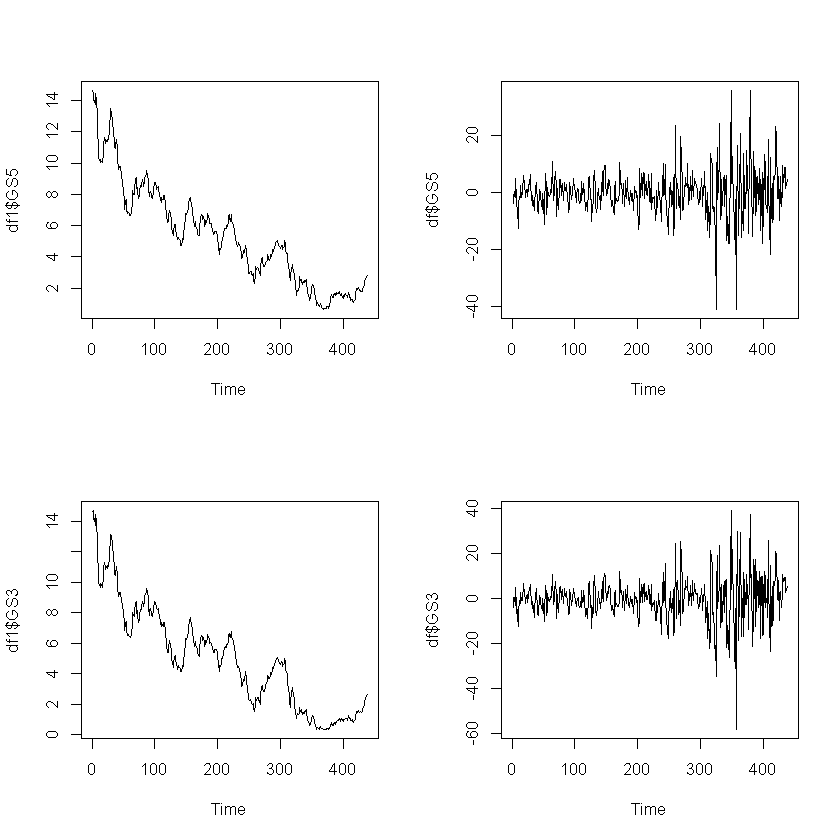

In [71]:
df = df %>% mutate(GS5=100*(log(GS5)-Lag(log(GS5), 1)), GS3=100*(log(GS3)-Lag(log(GS3), 1)))
par(mfrow=c(2, 2))
ts.plot(df1$GS5)
ts.plot(df$GS5)
ts.plot(df1$GS3)
ts.plot(df$GS3)

In [72]:
model = lm(GS3 ~ GS5, df)
summary(model)


Call:
lm(formula = GS3 ~ GS5, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.9574  -0.9263   0.0450   0.8492  12.9200 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.04602    0.12474   0.369    0.712    
GS5          1.15682    0.01597  72.458   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.602 on 434 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9236,	Adjusted R-squared:  0.9235 
F-statistic:  5250 on 1 and 434 DF,  p-value: < 2.2e-16


## **(1)** Test for violations of the following OLS assumption: $cov(u_t, u_{t-1})=0$

The consequences of ignoring autocorrelation when it is present are similar to those of ignoring heteroskedasticity. The OLS estimates are still unbiased, but they are not efficient nor consistent anymore (even in large sample sives). This means that the estimates of the standard errors are compromised, which implies that we should not trust on any statistic that uses it (i.e. p-values).


### **(a)** Durbin and Watson (1951) test

The DW is a test for first order autocorrelation of the residuals, that is, the relationship between the error term and its immediately previous value. In the context of regression model we have:

$
u_t = \rho u_{t-1} + v_t \quad v_t \sim N(0, \sigma^2)
$

The DW hypothesis formulation is given by:

$
H_0: \rho=0\\
H_1: \rho \neq 0
$

Note that its not necessary to run the above regression since the test statistic can be calculated using information available on the first fitted model. The test statistics is given by:

$
DW = \frac{\sum_{t=2}^{T}(\hat{u}_t - \hat{u}_{t-1})^2}{\sum_{t=2}^{T}\hat{u}_t^2}
$


The DW statistic does not follow traditional distribution like the chi-squared, t-dist, normal, or F. It has 2 critical values: an upper critical value given by $d_U$, and a lower critical value given by $d_L$, otherwise the result is inconclusive.

In our case, we use the regression of the residuals to test the hypothesis.

In [73]:
dwtest(model) 


	Durbin-Watson test

data:  model
DW = 1.5499, p-value = 1.18e-06
alternative hypothesis: true autocorrelation is greater than 0


The test statitics give us strong evidence that the null hypothesis of no first order autocorrelation has been violated.

### **(b)** Breusch and Godfrey autocorrelation test

The hypothesis of the test is as follows:


$H_0$: $\epsilon_t$ is uncorrelated 

$H_1$: $\epsilon_t$ is correlated up to order m
$

The test statistics is also based on the OLS residuals and is given by:

$
LM = T(\sum_{j=1}^{m}r^2_j) \quad where \quad r_j = \frac{\sum_{t=j+1}^{T}(\hat{\epsilon}_t-\hat{\epsilon}_{t-1})^2}{\sum_{t=1}^{T}\hat{\epsilon}^2_t}
$

Under the null hypothesis the LM statistics has a $\chi^2(m)$ distribution.


In [74]:
bgtest(model, order = 4)


	Breusch-Godfrey test for serial correlation of order up to 4

data:  model
LM test = 34.319, df = 4, p-value = 6.41e-07


The test statitics give us strong evidence that the null hypothesis of no m-order autocorrelation has been violated.

## **(2)** Propose corrections for violations of the assumption of no autocorrelation on the error terms:

The consequences of ignoring autocorrelation when it is present are similar to those of ignoring heteroskedasticity. The OLS estimates are still unbiased, but they are not efficient nor consistent anymore (even in large sample sives). This means that the estimates of the standard errors are compromised, which implies that we should not trust on any statistic that uses it (i.e. p-values).


There are a couple of ways to deal with autocorrelated error terms:

> 1. Cochrane-Orcutt procedure

> 2. White correction

> 3. Newey-West correction

> 4. Dynamic model

The first three solutions basically try to incorporate structure into the error terms by modifying the variance-covariance matrix, resulting in a GLS estimator. The last procedure is the easiest to implement and we will focus on that one.


### **(a)** Compare the static vs dynamic model in terms of AIC and BIC

In [76]:
df = df %>% mutate(GS3_l0 = GS3, GS3_l1 = Lag(GS3, 1),
                   GS3_l2 = Lag(GS3, 2), GS3_l3 = Lag(GS3, 3),
                   GS3_l4 = Lag(GS3, 4), GS3_l5 = Lag(GS3, 5))
aic_list = c()
bic_list = c()
for (i in 0:5){
    aic_list[i] = AIC(lm(as.formula(paste('GS3', paste0('GS3_l', toString(i)), sep = '~')), df))
    bic_list[i] = BIC(lm(as.formula(paste('GS3', paste0('GS3_l', toString(i)), sep = '~')), df))
}


In [77]:
cbind( c(0,1,2,3,4),aic_list, bic_list)

,aic_list,bic_list
0,3174.548,3186.774
1,3183.730,3195.950
2,3173.761,3185.973
3,3164.696,3176.901
4,3161.896,3174.095


We tested for 0 up to 5 lags in the regression and get the aic and bic values. We see that both aic and bic has its minimum with lag=4. Therefore, choose to include the forth lag in the model and repeat the BG autocorrelation test.

In [78]:
model1 = lm(GS3 ~ GS5 + GS3_l4, df)
summary(model1)


Call:
lm(formula = GS3 ~ GS5 + GS3_l4, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.5693  -0.9320   0.0382   0.8967  12.6243 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.02966    0.12547   0.236   0.8133    
GS5          1.15349    0.01604  71.899   <2e-16 ***
GS3_l4      -0.02877    0.01335  -2.155   0.0317 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.601 on 429 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.9245,	Adjusted R-squared:  0.9241 
F-statistic:  2627 on 2 and 429 DF,  p-value: < 2.2e-16


In [79]:
print(paste0('AIC static model: ', AIC(model), ' BIC static model: ', BIC(model), 'AIC dynamic model: ', AIC(model1), 'BIC dynamic model: ', BIC(model1)))

[1] "AIC static model: 2075.07691330925 BIC static model: 2087.3098400393AIC dynamic model: 2056.98178395981BIC dynamic model: 2073.25548631279"


In [80]:
bgtest(model1, order = 4)


	Breusch-Godfrey test for serial correlation of order up to 4

data:  model1
LM test = 33.857, df = 4, p-value = 7.971e-07


Note that by simply including the forth autoregressive term of the dependent variable into the regression does not solve for the serial autocorrelation, but in terms of BIC and AIC the dynamic model is better than the static one.


The persistence in the violation of the no serial autocorrelation hypothesis even when including the forth autocorrelated term can be due to a number os reasons:

> 1. The order of the lagged series was wornlgy chosen or multiple lags should be used

> 2. Omission of relevant exogenous variables, which are themselves autocorrelated

> 3. Unparameterised seasonality

> 4. Inappropriate functional form


## **(3)** Test for violations of the full rank assumption on the matrix $(X^{'}X)$ - no multicolinearity assumption.

An implicit assumption of the OLS estimator that guarantees the invertibility of $(X^{'}X)$ is that this matrix must be of full rank, that is, all variables in $X$ must be orthogonal.


In [81]:
x = as.data.frame(cbind(df$GS3, df$GS5, df$GS3_l4))
colnames(x) = c('GS3', 'GS5', 'GS3_l4')
cor(x, use = 'pairwise.complete.obs')

,GS3,GS5,GS3_l4
GS3,1.0000000,0.96106628,-0.12135884
GS5,0.9610663,1.00000000,-0.09666532
GS3_l4,-0.1213588,-0.09666532,1.00000000


Note that the 3-month trasury rate has an almost perfect multicolinearity

## **(4)** Test for violations of the parameter stability assumption:
### **(a)** Chow Test

Assume that we have splitted a sample o size $T$ into $T_1$ and $T_2$. Let us consider the following set of hypothesis:

$
H_0: H^{'}_0 \cup H^{''}_0 \quad where \quad H^{'}_0: \beta_1 = \beta_2 \quad and \quad H^{''}_0: \sigma^2_1 = \sigma^2_2\\
H_1: H^{'}_1 \cup H^{''}_1 \quad where \quad H^{'}_1: \beta_1 \neq \beta_2 \quad and \quad H^{''}_1: \sigma^2_1 \neq \sigma^2_2\\
$

If $T_2 > k$, the procedure is to estimate three models, one in the whole sample $T$, another in the first sample $T_1$, and finally the last one in the sample $T_2$. Let $RSS_j$ be the sum of the squared residuals, where $j \in \{T, T_1, T_2\}$, then the Chow test is given by:

$
CH_1 = (\frac{RSS_T - RSS_{T_1} - RSS_{T_2}}{RSS_{T_1} + RSS_{T_2}}) \frac{T-2k}{k}
$

Under the null we have that $CH_1 \sim F(k, T-2k)$.

The argument of the test is that, if the parameters are stable between samples, then $RSS_T$ will probably be close to $RSS_{T_1} + RSS_{T_2}$, otherwise the paremeters will be unstable.


In [82]:
sctest(GS3 ~ GS5 + GS3_l4, data = df, type = 'Chow', from = 50, to = 55)


	Chow test

data:  GS3 ~ GS5 + GS3_l4
F = 2.2061, p-value = 0.08675


Using the Chow test statistics we can take the significance level up to 8% more and still not reject the null hypothesis of parameter stability. Despite this value been relatively low, it is not lower than the typicall significance value threshold (0.05)